# Analysis of GRB 190114C with Fermi-LAT

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

00:47:29 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=728481;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=799331;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=144535;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=807508;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=138525;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=510798;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

00:47:31 ERROR     error                                                                           ]8;id=439782;file:///var/folders/t5/14gs56bj7djcylkj26c908n40000gn/T/ipykernel_20557/3699701126.py\3699701126.py]8;;\:]8;id=389356;file:///var/folders/t5/14gs56bj7djcylkj26c908n40000gn/T/ipykernel_20557/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=997683;file:///var/folders/t5/14gs56bj7djcylkj26c908n40000gn/T/ipykernel_20557/3699701126.py\3699701126.py]8;;\:]8;id=408977;file:///var/folders/t5/14gs56bj7djcylkj26c908n40000gn/T/ipykernel_20557/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

00:48:01 INFO      Query parameters:                                                       ]8;id=945057;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=3407;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=331993;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=520429;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=393172;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=683626;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=992572;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=135004;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=195629;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=788745;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=436980;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=502132;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=215516;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=130578;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=215773;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=52052;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=635958;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=545011;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=413735;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=69277;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=495939;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=817819;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

00:48:02 INFO      Estimated complete time for your query: 15 seconds                      ]8;id=152625;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=349794;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=235352;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=271380;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2410242                         
                  048030E96CEF294 (when ready)                                                                     

00:48:15 INFO      Downloading FT1 and FT2 files...                                        ]8;id=315328;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=988376;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

00:48:19 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=701445;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=518690;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.12
user 0.09
sys 0.02
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...

time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbindef version HEAD
real 0.05
user 0.02
sys 0.01
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.74
user 2.55
sys 0.17

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy=strategy)

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.11
user 0.07
sys 0.02

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=

Done.
real 0.13
user 0.10
sys 0.02

Selected 251 events.


00:48:22 INFO      Extracted 251 events                                                    ]8;id=687761;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=587563;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

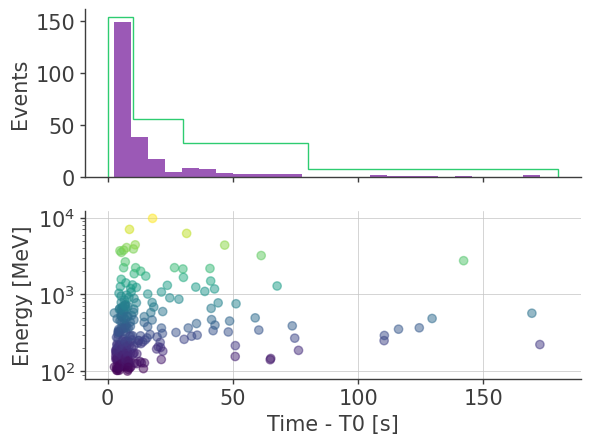

In [8]:
%matplotlib inline
with pyfits.open(myLATdataset.filt_file) as event_file:
    lat_events = event_file["EVENTS"].data
event_times = lat_events["TIME"] - myGRB["MET"]

intervals = [0, 10, 30, 80, 180]
fig, axs = plt.subplots(2, 1, sharex=True)
plt.sca(axs[0])
plt.hist(event_times)
plt.hist(event_times, intervals, histtype="step")
plt.ylabel("Events")
plt.sca(axs[1])
plt.scatter(
    event_times,
    lat_events["ENERGY"],
    marker="o",
    c=lat_events["ENERGY"],
    norm="log",
    alpha=0.5,
    zorder=20,
)
plt.yscale("log")
plt.ylabel("Energy [MeV]")
plt.xlabel("Time - T0 [s]")
plt.grid(True)

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
print(tstarts)
tstops = tstops[:-1].replace("-", "\\-")
print(tstops)

0.0000,10.0000,30.0000,80.0000
10.0000,30.0000,80.0000,180.0000


We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                      190114873
roi                                                 10
tstarts                 0.0000,10.0000,30.0000,80.0000
tstops                10.0000,30.0000,80.0000,180.0000
zmax                                             110.0
emin                                             100.0
emax                                          100000.0
irf                                   p8_transient020e
galactic_model                                template
particle_model                          isotr template
source_model                                 PowerLaw2
tsmin                                             20.0
strategy                                          time
thetamax                                         180.0
spectralfiles                                       no
liketype                                      unbinned
optimizeposition                                    no
datarepository                                       .
ltcube    

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [11]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

00:48:23 INFO      Changing permission to                                              ]8;id=167040;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=309196;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py                                                      

         INFO      Changing permission to                                              ]8;id=615605;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=48784;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtdiffrsp_mp.py                                                          

         INFO      Changing permission to                                              ]8;id=234992;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=746012;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtexpmap_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=362650;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=159474;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtltcube_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=701421;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=461333;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gttsmap_mp.py                                                            

         INFO      About to run the following command:                                 ]8;id=682699;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=78619;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#640\640]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '0.0000,10.0000,30.0000,80.0000' --tstops                                                        
                  '10.0000,30.0000,80.0000,180.0000' --zmax 110.000000 --emin                                      
                  100.000000 --emax 100000.000000 --irf 'p8_transient020e'                                         
                  --galactic_model 'template' --particle_model 'isotr template'                                    
                  --source_model 'PowerLaw2' --tsmin 20.000000 --strategy 'time'                                   
                  --thetamax 180.000000 --spectralfiles 'no' --liketype 'unbinned'                                 
                  --optimizeposition 'no' --datarepository '.' --ltcube '' --expomap                               
                  '' --ulphindex -2.000000 --flemin 100.000000 --flemax 10000.000000                               
                  --fgl_mode 'fast'                                                                                

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   271.7361     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .61E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  7.4%

  EXT PARAMETER                            

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   204.5496     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .29E-06    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
0.0                  - 10.0
10.0                 - 30.0
30.0                 - 80.0
80.0                 - 180.0

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file              /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
rspfile              /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp
cspecfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.pha

ROI:
-----
R.A.                 54.51
Dec.                 -26.939
Radius               10.0

Interval # 1 (0.0-10.0):
-----------------------

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn19011487

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   144.6357     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .83E-05    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   62.16513     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .68E-05    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.0-30.0/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_10.0-30.0.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.0-30.0/gll_ft1_tr_bn190114873_v00_filt.fit............................!
real 11.22
user 10.42
sys 0.78
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML

00:51:14 INFO      The ft2 file does not exist. Please examine!                        ]8;id=588592;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=612013;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=427522;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=927361;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=665771;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=377513;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval0.0-10.0/gll_ft2_tr_bn190114873_v00.fit                                                  

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=326077;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=340479;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=68863;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=310399;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=515068;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=965650;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval10.0-30.0/gll_ft2_tr_bn190114873_v00.fit                                                 

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=168441;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=832209;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=132271;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=722341;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=221999;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=759606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval30.0-80.0/gll_ft2_tr_bn190114873_v00.fit                                                 

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=577689;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=39878;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=975645;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=36798;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=286037;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=20408;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval80.0-180.0/gll_ft2_tr_bn190114873_v00.fit                                                

 At this point we can create the FermiLATLike plugins from each of the observation:

In [12]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  10.0
FermiLATLike - GTI SUM =  20.0


FermiLATLike - GTI SUM =  50.0
FermiLATLike - GTI SUM =  97.97399997711182


For reference, these are the keys save in the dictionary.


In [13]:
LAT_plugins.keys()

dict_keys(['LAT_00.000-10.000', 'LAT_10.000-30.000', 'LAT_30.000-80.000', 'LAT_80.000-180.000'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [14]:
results = {}
# update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

00:51:15 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=261473;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=750604;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



00:51:25 INFO      set the minimizer to minuit                                             ]8;id=71624;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=693394;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=420147;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=731760;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         WARNING   49.980000000000004 percent of samples have been thrown away because     ]8;id=651417;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=751347;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.11 -0.09 +0.10) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.22 +/- 0.10,
LAT0X10_IsotropicTemplate_Normalization,5.00 +/- 0.08,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT0X10,896.873532
total,896.873532


Values of statistical measures:

,statistical measures
AIC,1799.907064
BIC,1808.857922


00:51:25 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=379714;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=143746;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



00:51:33 INFO      set the minimizer to minuit                                             ]8;id=966049;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=567787;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=627443;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=197729;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         WARNING   49.980000000000004 percent of samples have been thrown away because     ]8;id=210757;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=880331;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1737\1737]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.73 -0.23 +0.26) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.13,
LAT10X30_IsotropicTemplate_Normalization,5.000 +/- 0.006,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X30,377.045804
total,377.045804


Values of statistical measures:

,statistical measures
AIC,760.553147
BIC,766.167663


00:51:33 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=983859;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=667120;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



00:51:43 INFO      set the minimizer to minuit                                             ]8;id=186864;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=867664;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=129301;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=473296;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         WARNING   50.42 percent of samples have been thrown away because they failed the  ]8;id=977826;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=266785;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(4.2 -0.7 +0.8) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.51 +/- 0.15,
LAT30X80_IsotropicTemplate_Normalization,(1.0 +/- 1.0) x 10^-1,


Correlation matrix:

1.00,-0.28,-0.00
-0.28,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X80,229.690242
total,229.690242


Values of statistical measures:

,statistical measures
AIC,466.208071
BIC,469.870007


00:51:43 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=397886;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=723964;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



00:51:57 INFO      set the minimizer to minuit                                             ]8;id=539219;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=444354;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=547946;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=519043;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         WARNING   50.0 percent of samples have been thrown away because they failed the   ]8;id=847627;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=549677;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1737\1737]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.7 -2.5 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.7 +/- 0.4,
LAT80X180_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.40,-0.00
-0.40,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT80X180,73.102184
total,73.102184


Values of statistical measures:

,statistical measures
AIC,158.204369
BIC,152.442693


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.11 -0.09 +0.10) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.22 +/- 0.10,
LAT0X10_IsotropicTemplate_Normalization,5.00 +/- 0.08,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT0X10,896.873532
total,896.873532


Values of statistical measures:

,statistical measures
AIC,1799.907064
BIC,1808.857922


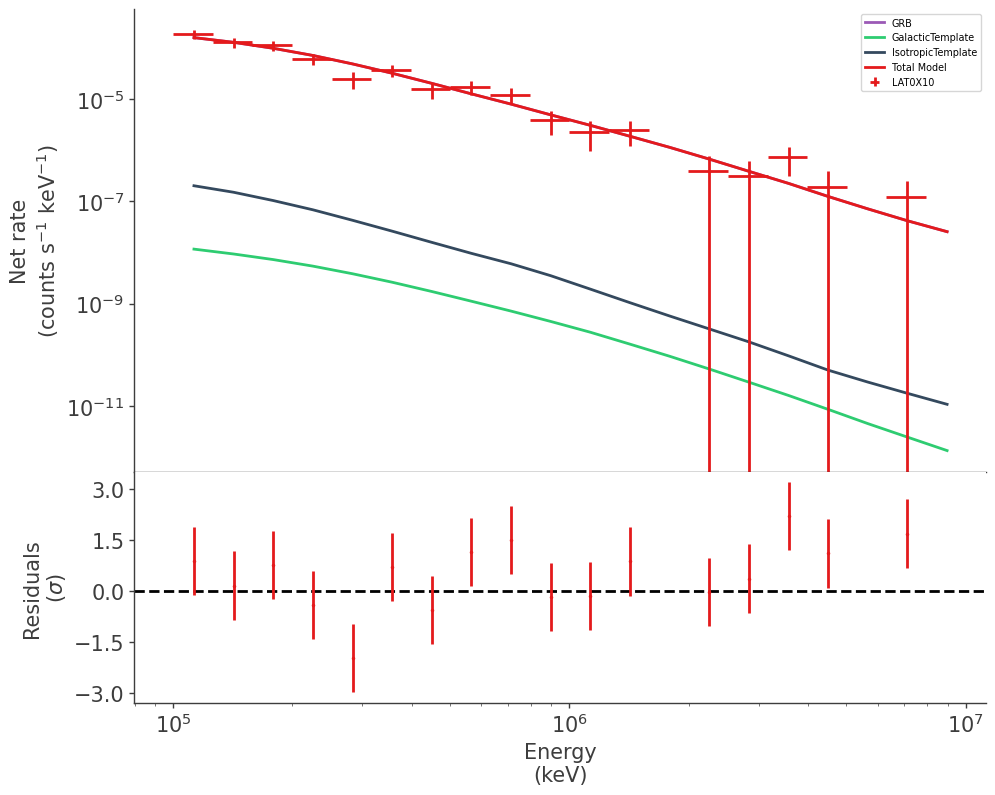

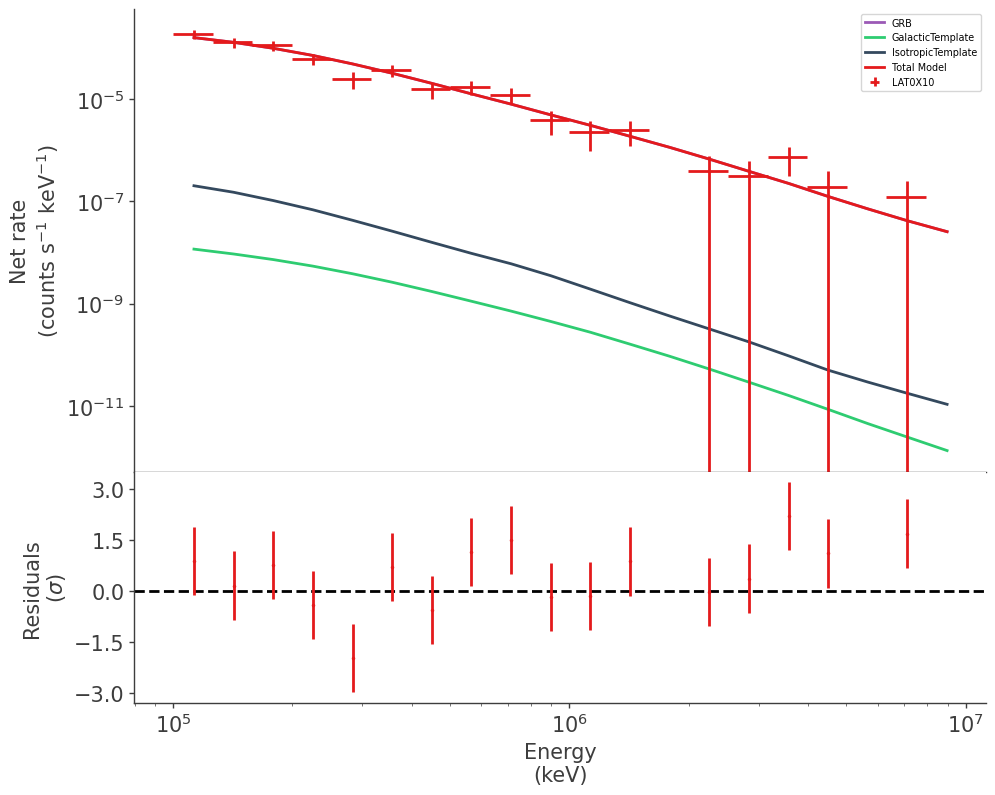

In [15]:
i = 0
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, figsize=(10, 8))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/4 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

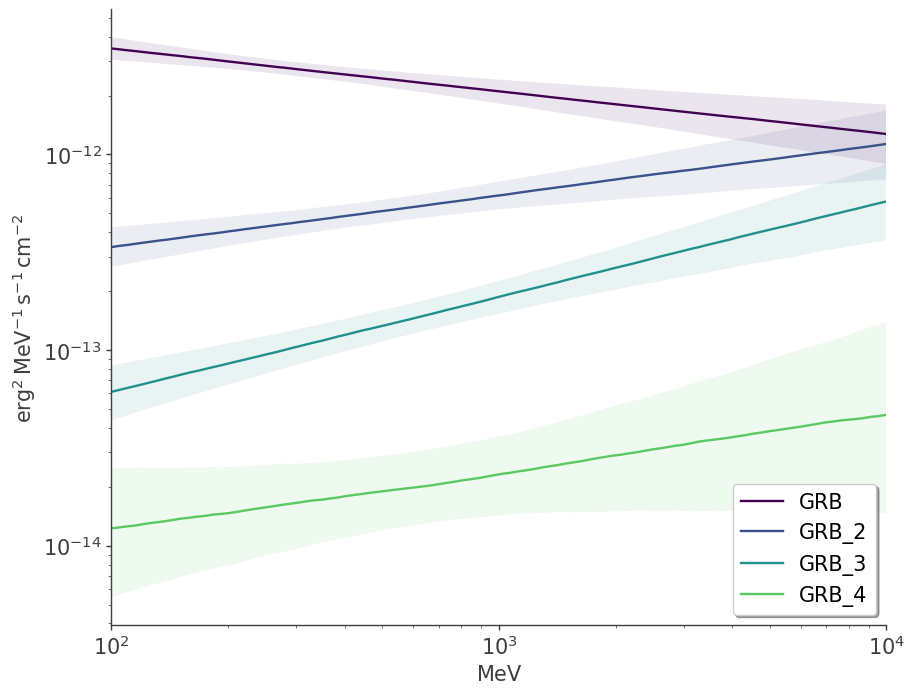

In [16]:
fig = plot_spectra(
    *[a.results for a in results.values()],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 8)

Finally, we can display flux lightcurves and index evolution with time.


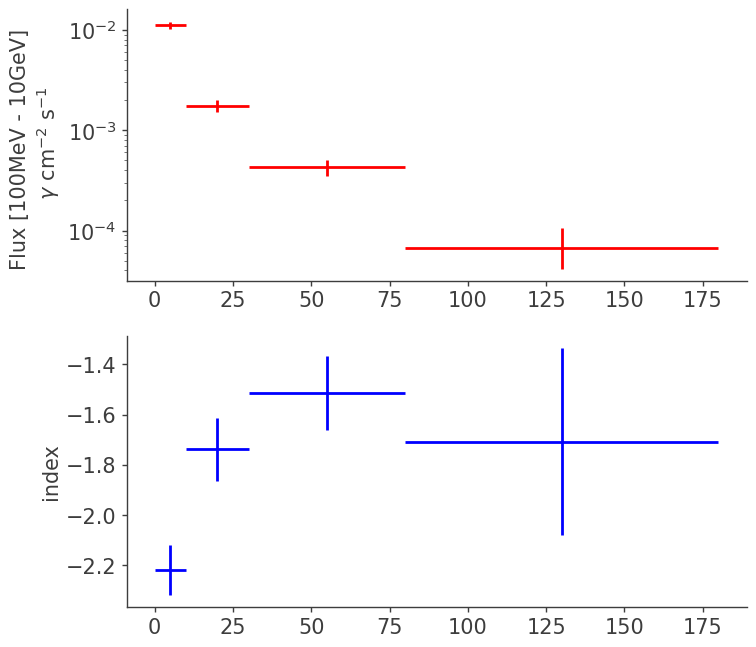

In [17]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])

fig = plt.figure(figsize=(8, 12))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    plt.ylabel(ylabels[i])